In this notebook, we will attempt to debug why we're consistently getting NANs when attempting to train. Let's run it: 

In [37]:
# ipython extension to autoreload imported modules so that any changes will be up to date before running code in this nb
%load_ext autoreload 
%autoreload 2

In [38]:
import ml_collections

from utils.jraph_training import train_and_evaluate_with_data, create_dataset, evaluate_model, rollout
# from utils.jraph_models import MLPGraphNetwork
from utils.jraph_data import print_graph_fts
from utils.jraph_vis import plot_predictions
import ml_collections
import optuna 
from flax import linen as nn
from functools import partial
from datetime import datetime
import os 
import tempfile
import matplotlib.pyplot as plt 
import numpy as np 

import jax
from utils.jraph_training import create_dataset, create_model, create_optimizer
from clu import checkpoint
from clu import parameter_overview
from flax.training import train_state

In [39]:
def create_config(seed, connected=None):
    config = ml_collections.ConfigDict()

    # Data params. 
    config.n_samples=5000
    config.input_steps=1
    config.output_delay=0 # predict 0 hours into the future
    config.output_steps=4
    config.timestep_duration=3
    config.sample_buffer=-1 * (config.input_steps + config.output_delay + config.output_steps - 1) # negative buffer so that our sample input are continuous (i.e. the first sample would overlap a bit with consecutive samples) 
    config.time_resolution=120
    config.init_buffer_samples=0
    config.train_pct=0.7
    config.val_pct=0.2
    config.test_pct=0.1
    config.K=36
    config.F=8
    config.c=10
    config.b=10
    config.h=1
    config.seed=seed
    config.normalize=True
    config.fully_connected_edges=connected

    # Optimizer.
    config.optimizer = 'sgd'
    config.learning_rate = 0.00045346796177033903
    config.momentum = 0.8712873602503628

    # Training hyperparameters.
    # config.batch_size = 3
    config.epochs = 30
    config.log_every_epochs = 5
    config.eval_every_epochs = 5
    config.checkpoint_every_epochs = 10
    config.max_checkpts_to_keep = None # None means keep all checkpoints

    # GNN hyperparameters.
    config.model = 'MLPGraphNetwork'
    config.n_blocks = 1
    config.activation = 'relu'
    config.dropout_rate = 0.013287043114620523
    config.skip_connections = False # This was throwing a broadcast error in add_graphs_tuples_nodes when this was set to True
    config.layer_norm = False # TODO perhaps we want to turn on later
    config.edge_features = (8, 8) # the last feature size will be the number of features that the graph predicts
    config.node_features = (32, 2)
    config.global_features = None
    config.share_params = False
    return config

In [40]:
from utils.lorenz import load_lorenz96_2coupled, run_download_lorenz96_2coupled, run_lorenz96_2coupled
from utils.lorenz96_plotter import plot_Lorenz96

In [41]:
# set up logging
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [97]:
t, X, F, K, n_steps = run_lorenz96_2coupled(
        K=36,
        F=8,
        c=10,
        b=10,
        h=1,
        n_steps=15000,
        resolution=100,  # 100
        seed=42)

INFO:root:starting integration


x1 max:  14.152405851292691
x1 max threshold 16.670939219746614
x1 min:  -9.268787258358218
x1 min threshold -11.536529250831926
x2 max:  2.717011615884856
x2 max threshold 7.689354061922447
x2 min:  -2.6637126064476564
x2 min threshold -7.45703408241263


INFO:root:starting integration


x1 max:  13.585896984257825
x1 max threshold 20.358535505327897
x1 min:  -8.441847332216632
x1 min threshold -15.095176099847997
x2 max:  5.027638475496205
x2 max threshold 5.927738888046331
x2 min:  -7.450116541109949
x2 min threshold -5.7042647651713345
True
First component
Second Component


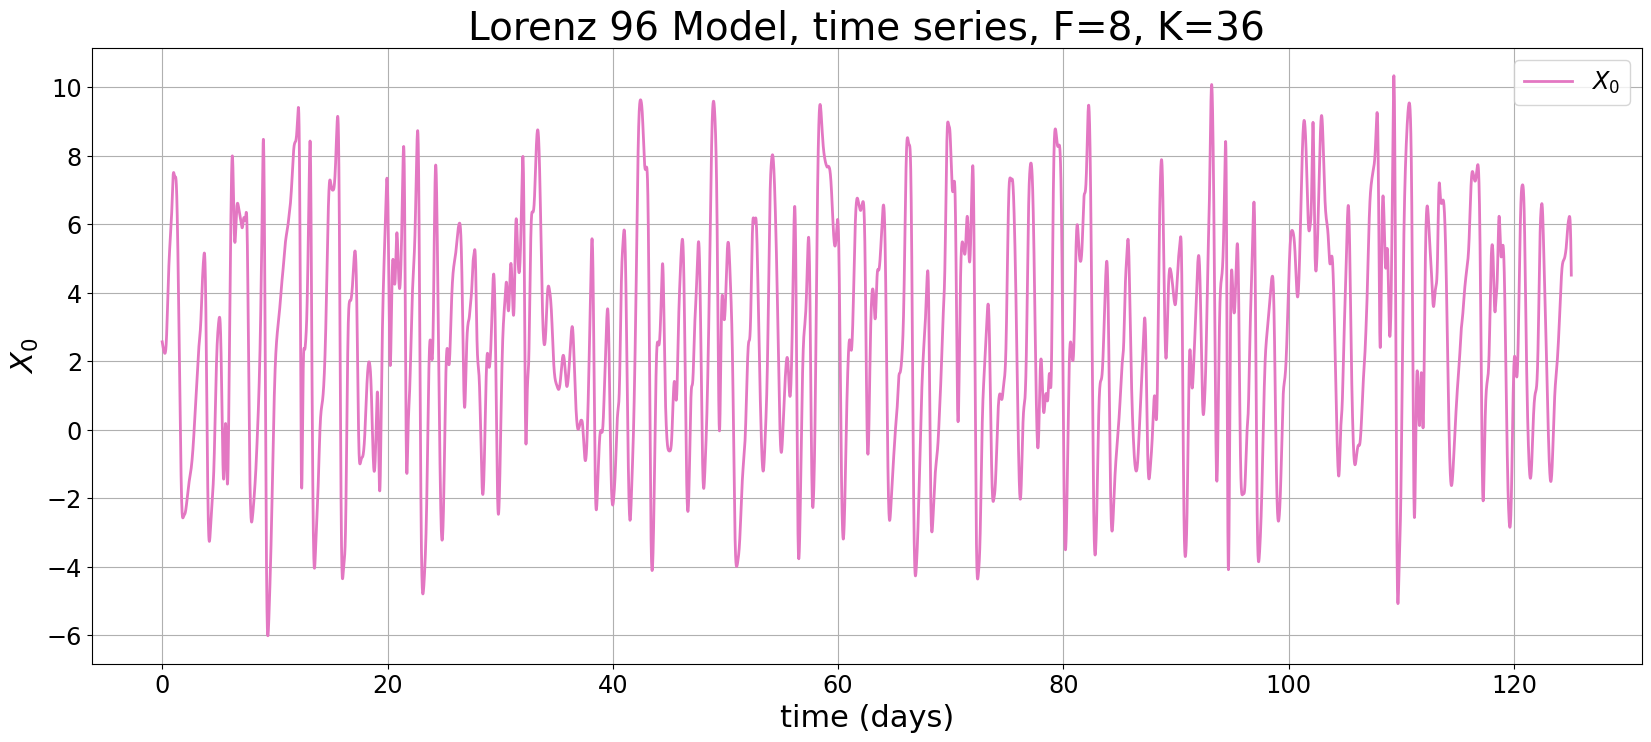

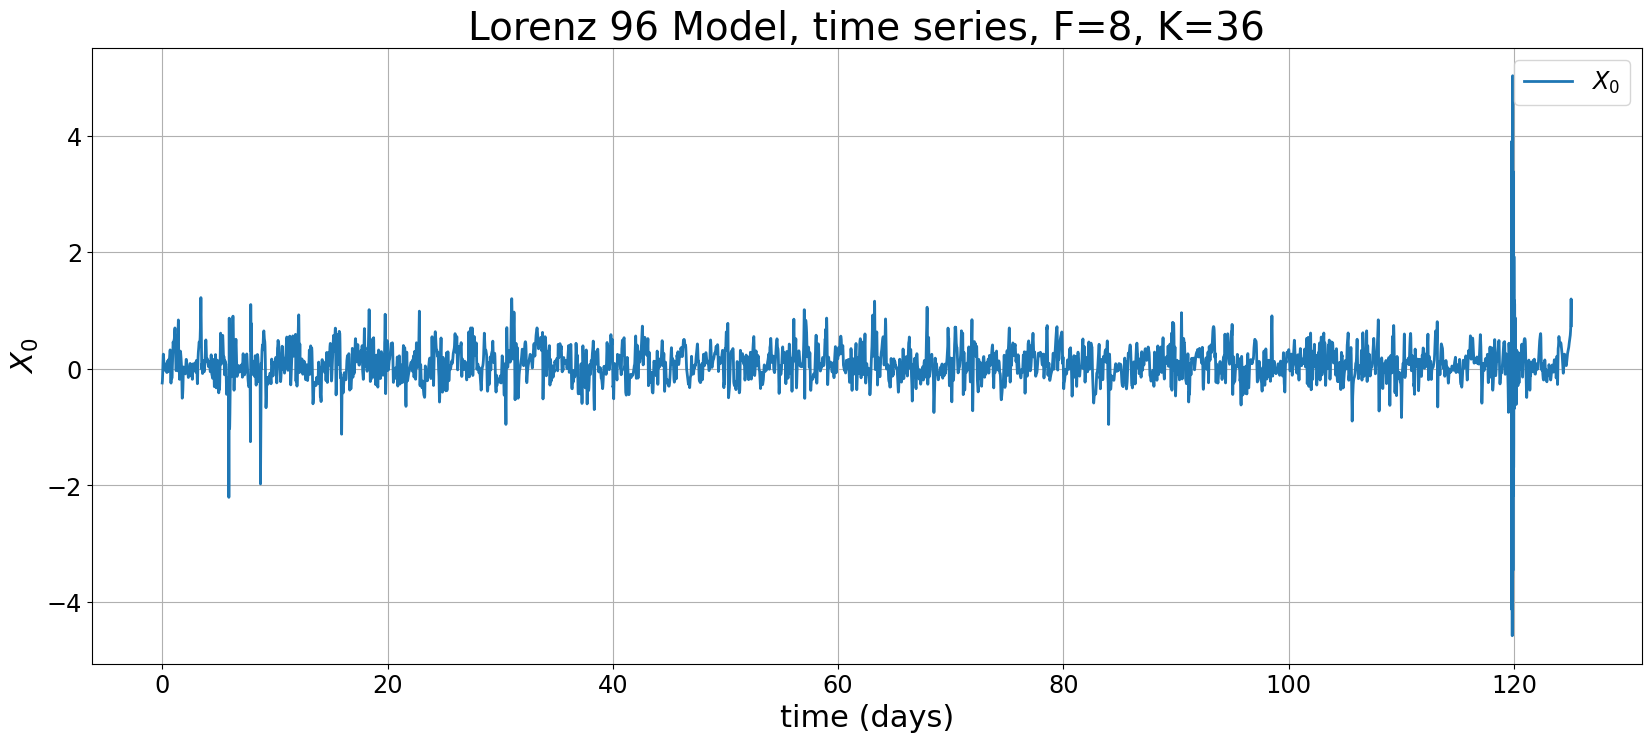

In [114]:
config = create_config(52, connected=False)

t, X, F, K, n_steps = run_lorenz96_2coupled(
        K=36,
        F=8,
        c=10,
        b=10,
        h=1,
        n_steps=15010,
        resolution=120,
        seed=config.seed)

plot_Lorenz96(True, False, X, t, 8, 36, config.n_samples, config.time_resolution)

In [112]:
def plot_data(
        config,
        plot_ith_rollout_step, # 0 indexed 
        node, # 0-indexed 
        plot_mode, # i.e. "train"/"val"/"test"
        datasets=None,
        plot_days=None, # if None, plot entire time series; otherwise plot specified number of days 
        title=''):
    assert plot_mode in ["train", "val", "test"]

    # samples must be overlapping and consecutive for this plot to really be interpretable the way it is meant 
    assert (
        config.input_steps + config.output_delay + config.output_steps + config.sample_buffer == 1
        )

    # Get datasets, organized by split.
    if datasets is None:
        datasets = create_dataset(config)

    plot_set = datasets[plot_mode]
    target_data = plot_set['targets']
    # n_rollout_steps = config.output_steps

    node_targets = []

    if plot_days is not None:
        plot_count = plot_days * config.time_resolution / 5 / config.timestep_duration
    else:
        plot_count = len(target_data)

    for i, target_window_graphs in enumerate(target_data):
        if i >= plot_count:
            break
        # also grab the target nodes while we're in this loop 
        ith_rollout_target = target_window_graphs[plot_ith_rollout_step].nodes
        node_target = ith_rollout_target[node, :] # jnp array with shape (1, 2)
        node_targets.append(node_target)

    node_targets = np.vstack(node_targets)

    # reconstruct timesteps
    steps = np.arange(plot_count)
    # convert timesteps from step index to day 
    t_days = steps * config.timestep_duration * 5 / config.time_resolution 

    # set up plot
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(15, 10), sharex=True) 

    # plot rollout targets
    ax0.plot(
        t_days,
        node_targets[:, 0],
        # s=5,
        alpha=0.8,
        linewidth=4,
        label='Target',
        c='#7170b5')
    ax1.plot(
        t_days,
        node_targets[:, 1], 
        alpha=0.8, 
        linewidth=2,
        label='Target', 
        c='#7170b5')

    if title == '':
        fig.suptitle(f"{plot_mode.title()} data for node {node}", size=45)
    else:
        fig.suptitle(title, size=45)
    # ax0.set_title("X", size=40)
    # ax1.set_title("Y", size=40)
    plt.xlabel('Time (days)', size=35, labelpad=30)
    ax0.set_ylabel("X", size=35)
    ax1.set_ylabel("Y", size=35)

    ax0.legend(loc="upper right")
    # ax1.legend(loc="upper left")

INFO:root:starting integration


x1 max:  13.82609276372255
x1 max threshold 20.11069073117261
x1 min:  -8.904212680175995
x1 min threshold -15.075297231746333
x2 max:  9.192431884436957
x2 max threshold 5.893575962346117
x2 min:  -3.86468500475814
x2 min threshold -5.658281526357721
True


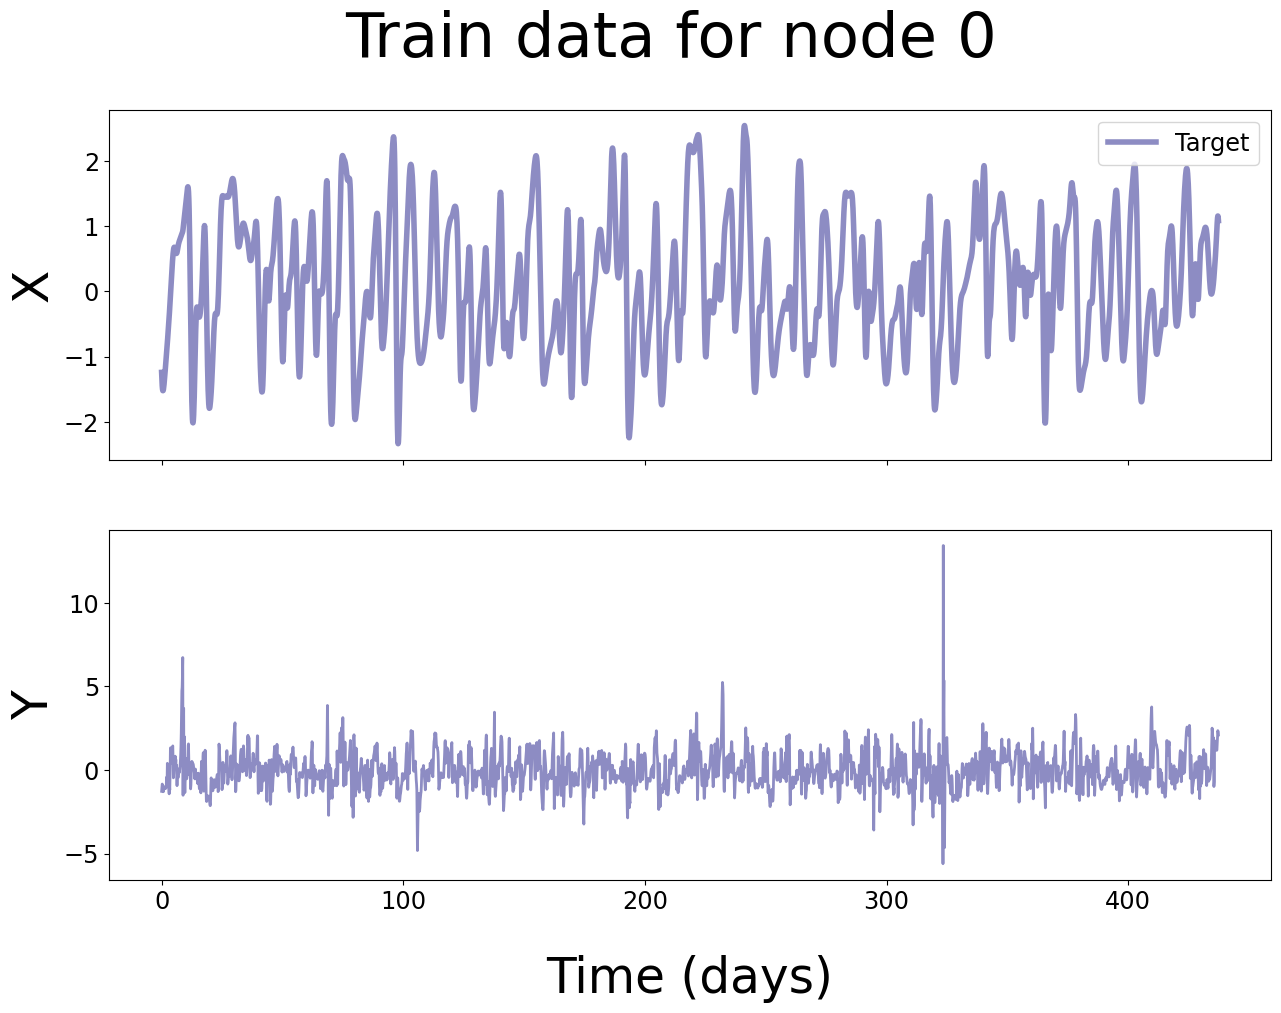

In [113]:
plot_data(config=config,
          plot_ith_rollout_step=0,
          node=0,
          plot_mode='train')